# Notebook 2: Data cleaning and structuring, and Logistic Regression

### Libraries used for all notebooks 

In [535]:
# Import libaries
import requests
from bs4 import BeautifulSoup
import pandas as pd
from scrapy.selector import Selector
from scrapy.http import HtmlResponse
import re
import time
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np
from matplotlib_venn import venn2, venn2_circles

In [536]:
!pip install wordcloud

### Importing CSV files
Previously exported CSV files in Notebook 1 are imported in to perform cleaning

In [537]:
#importing CSV files 
rships = pd.read_csv("../datasets/rships.csv", index_col = 'Unnamed: 0')
jnm = pd.read_csv("../datasets/jnm.csv", index_col = 'Unnamed: 0')

### Setting up the combined dataframes

The dataframes for the separate reddit data were set up so that they can be easily combined. 
Steps:

1. Text columns were renamed to 'posts'

2. Subreddit were numbered 0 for r/relationship_advice and 1 for r/justnomil

In [538]:
#renaming text column to posts
rships.columns = ['posts']
jnm.columns = ['posts']

In [539]:
#creating new columns denoting what subreddit 
rships['subreddit'] = 0
jnm['subreddit'] = 1

### A look at the separate dataframes 

Both 5 rows of both dataframes show that there is correct encoding of subreddit number.

In [540]:
#visual inspection of the data
jnm.head()

,posts,subreddit
0,"Does your MIL suck, but you don't feel like ma...",1
1,A thread that is our own kind of /r/awww or /r...,1
2,I had an antenatal appointment yesterday as I'...,1
3,"First off, thank you to everyone who has been ...",1
4,That's what my JNMIL told me the last time we ...,1


In [541]:
rships.head()

,posts,subreddit
0,**TL;DR on Throwaways:** If you wish to reques...,0
1,Since two or three times a week we end up remo...,0
2,"My original post was locked due to a cap , I j...",0
3,[Original post](https://www.reddit.com/r/relat...,0
4,(Reposted this after the moderators removed th...,0


## Visual look at the distribution of posts

Histograms showing the distribution of post length per post were plotted.

Text(0.5, 1.0, 'Histogram of distribution of posts from r/justnomil')

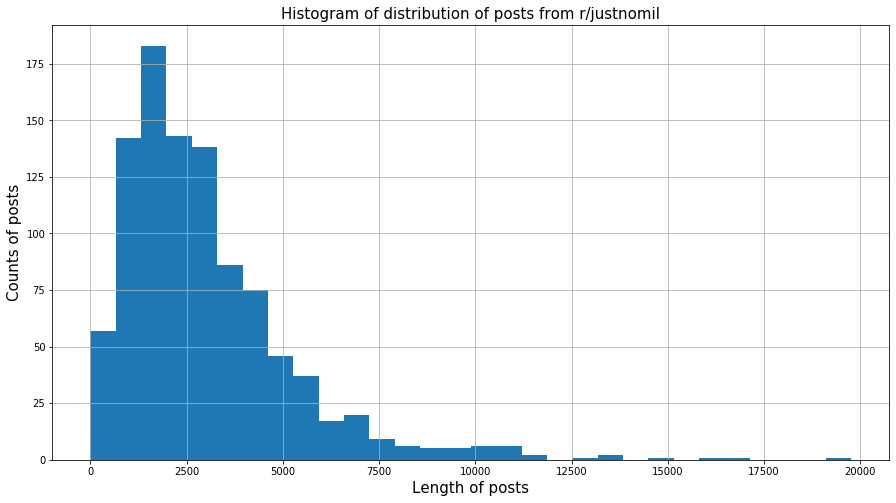

In [542]:
#distribution of length of posts for r/justnomil
plt.figure(figsize = (15,8))
plt.grid()
plt.hist([len(x) for x in jnm['posts']], bins = 30)
plt.ylabel('Counts of posts', size=15)
plt.xlabel('Length of posts', size=15)
plt.title('Histogram of distribution of posts from r/justnomil', size = 15)

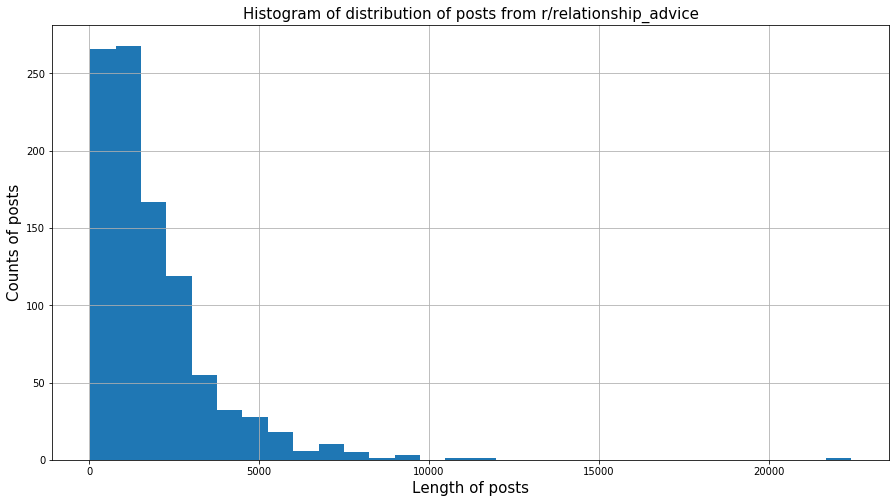

In [678]:
#distribution of length of posts from r/relationship_advice
plt.figure(figsize = (15,8))
plt.hist([len(x) for x in rships['posts']], bins = 30)
plt.ylabel('Counts of posts', size=15)
plt.xlabel('Length of posts', size=15)
plt.title('Histogram of distribution of posts from r/relationship_advice', size = 15)
plt.grid()

Both distributions do not look normally distributed. Most posts seem to be under 5000 character length and do not have posts that are above 12000 characters long.

### Wordcloud of frequency of paired words present in the posts

A word cloud showing all the most frequent paired words in each subreddit.

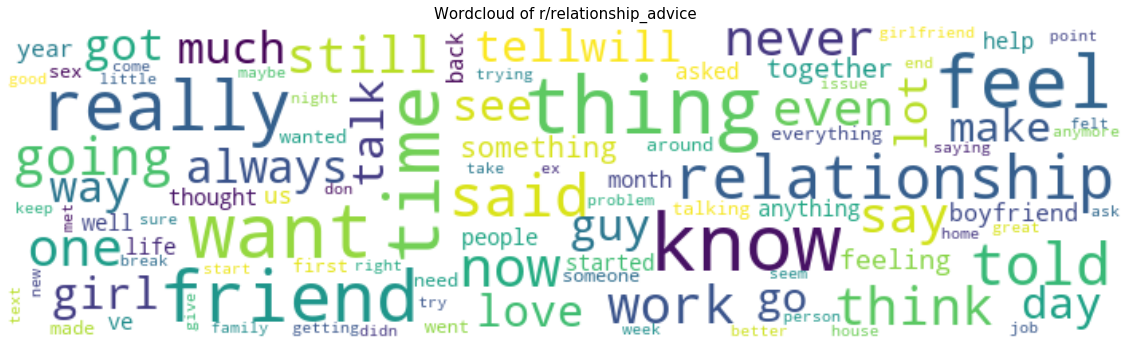

In [679]:
text = " ".join(e for e in rships['posts'])

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", width=700).generate(text)
# Save image file 
wordcloud.to_file("./bag_of_words.png")

# Display the generated image:
plt.figure(figsize = (20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud of r/relationship_advice', size = 15)
plt.show()

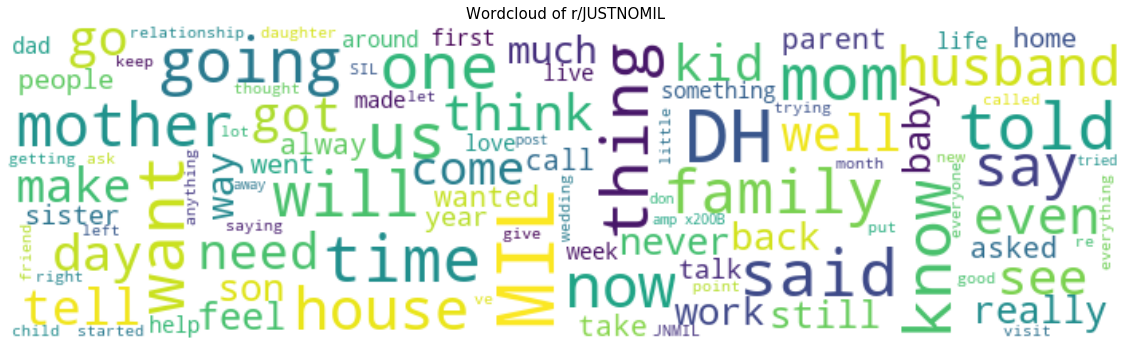

In [545]:
text = " ".join(e for e in jnm['posts'])

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", width=700).generate(text)
# Save image file 
wordcloud.to_file("./bag_of_words.png")

# Display the generated image:
plt.figure(figsize = (20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud of r/JUSTNOMIL', size = 15)
plt.show()

Both word clouds show that both subreddits have keywords from their own name as one of the more common words. There are more obvious differences in family members mentioned - DH (acronym: Dear Husband) and mother in r/JUSTNOMIL, and friend and work in r/relationship_advice.

In [546]:
#finding out how many posts were taken from each subreddit
print(len(rships), len(jnm))

981 990


In [547]:
#checking if anything were duplicate entries
print(len(rships.duplicated(keep='first'))) #no change in resulting length
print(len(jnm.duplicated(keep='first'))) #no change in resulting length

981
990


### Combining the dataframes together

Both dataframes are appended together as they share same columns.

In [548]:
# appending the dataframes together
combined = rships.append(jnm)

In [549]:
#reseting the index to prevent duplicated index numbers
combined = combined.reset_index(drop = True)

In [550]:
combined.tail()

,posts,subreddit
1966,"Trigger warning: mentions suicide\n\nSo, movin...",1
1967,For context I have 2 older brothers. B1 is her...,1
1968,"Ambivalent for flair, but advice is okay. See ...",1
1969,I had two woooonderful weeks without seeing my...,1
1970,TLDR; my ex and I broke up this summer because...,1


In [551]:
combined.shape

(1971, 2)

### Cleaning of text into clean text without punctuations and stopwords

The following steps were taken: 

1. Removing HTML tags to get text only

2. Making all letters lower case and then splitting them into individual words

3. Removing `mil` and `relationships` and `advice` from the posts

4. Stemming the posts using the Lemmatizing tool

5. Initializing stopwords as a set

6. Removing stopwords from the posts

7. Joining the posts back

In [552]:
#importing of stopwords
stopwords = stopwords.words('english')

In [553]:
def clean(text):
    # Function to convert a raw review to a string of words
   
    # 1. Remove HTML.
    new_text = BeautifulSoup(text).get_text()
    
    # 2. Remove non-letters.
    no_links = re.sub("\(https\S+\)", " ", new_text)
    letters_only = re.sub("[^a-zA-Z]", " ", no_links)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. Remove 'mil', 'relationships', 'relationship', 'advice' as they are in the topic
    topic_words = ['mil', 'relationships', 'relationship', 'advice']
    new_words = [w for w in words if not w in topic_words]
    
    # 5. Initiate Lemmatizer and stem the text
    lemma = WordNetLemmatizer()
    stemmed = [lemma.lemmatize(x) for x in new_words]
    
    # 6. In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set.
    stops = set(stopwords)
    
    # 7. Remove stop words.
    meaningful_words = [w for w in stemmed if not w in stopwords]
    
    # 8. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [554]:
#visual inspection
combined['posts'][981]

"Does your MIL suck, but you don't feel like making an entire post about it? Is she a BEC and you just want to vent about the crumbs in your carpet for a moment? Post here!"

In [555]:
combined['posts'] = [clean(x) for x in combined['posts']]

/Users/ongzhongliang/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning: "https://www.reddit.com/r/teenagers/comments/dm6gwg/i_wanna_give_up_but_she_keeps_reeling_me_back_in/?utm_medium=android_app&amp;utm_source=share" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [556]:
#visual inspection of post after cleaning
combined['posts'][981]

'doe suck feel like making entire post bec want vent crumb carpet moment post'

Though PorterStemmer can have an advantage over Lemmatizers, the resulting paragraph is often crude and difficult to interpret and relate back. In addition lemmatizers consider the context of the content, and so it was chosen.

`mil` and `relationships` and `advice` were removed from the classifier in the view of being able to classify the posts without the use of the keywords, though `mil` is a very common acronymn in r/JUSTNOMIL.

### Baseline accuracy

In [557]:
combined.subreddit.value_counts(normalize = True)

1    0.502283
0    0.497717
Name: subreddit, dtype: float64

There is an almost 50% distribution between r/relationships and r/JUSTNOMIL posts.

### Analysis of words

The data is split into training and test sets so a model could be created to predict if a post is either from r/relationships or r/justnomil. The default test size of 25% of the total caaes were chosen, and was stratified accourding to subreddit type

In [558]:
# making train test split of data
X_train, X_test, y_train, y_test = train_test_split(combined['posts'],
                                                    combined['subreddit'],
                                                    stratify= combined['subreddit'],
                                                    random_state = 42)

In [559]:
#shape of the series
X_train.shape

(1478,)

## Vectorizing

A pipeline using TF-IDF vectorizer and logistic regression was created to find optimal conditions for TF-IDF vectorizer parameters.

TF-IDF vectorizer was chosen as the choice vectorizer as it penalised more common words and promoted rarer words.

In [560]:
# Pipeline was created
pipecveclr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
                ])

In [561]:
# the parameters to be tested by the pipeline 
paramcveclr = {'cvec__max_features': [2000, 2500, 3000, 3500],\
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)]}

In [562]:
#gridsearch was initialised and the training set was fitted into it
gridcveclr = GridSearchCV(pipecveclr, param_grid=paramcveclr, cv = 5, verbose = 1)
gridcveclr.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ongzhongliang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  9.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'cvec__max_features': [2000, 2500, 3000, 3500], 'cvec__min_df': [2, 3], 'cvec__max_df': [0.9, 0.95], 'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [563]:
#the parameters that gave the best score
gridcveclr.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 2500,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1)}

In [564]:
gridcveclr.best_score_

0.9330175913396481

In [566]:
# using the same parameters, the score was generated for the test datasets
gridcveclr.score(X_test, y_test)

0.920892494929006

GridSearch showed that there is a high score for logistic regression with CountVectoriser possible.

### Initialising CountVectoriser with found parameters.

In [567]:
# tfidfvectorizer was initialised with the parameters that was found using gridsearch
cveclr = CountVectorizer(max_df = 0.9, max_features = 2500, min_df = 3, ngram_range=(1,1))

In [568]:
#X_train data fit graph and the words were vectorised into different columns
X_train_cveclr = pd.DataFrame(cveclr.fit_transform(X_train).toarray(),columns = cveclr.get_feature_names()) 

In [569]:
#list of words vectorised
cvec_col_lr = cveclr.get_feature_names()

In [570]:
print(X_train_cveclr.shape)

(1478, 2500)


In [571]:
#X_test words were vectorised into different columns
X_test_cveclr = pd.DataFrame(cveclr.transform(X_test).toarray(), columns = cveclr.get_feature_names()) #transform the X_test data

#### Logistic Regression was performed

In [572]:
# logistic regression initialised
lrc = LogisticRegression()

In [573]:
# X_train data fitted
modellrc = lrc.fit(X_train_cveclr, y_train)

In [574]:
#score for model was found
scorelrc = lrc.score(X_test_cveclr, y_test)

In [575]:
scorelrc

0.920892494929006

The expected score was reached. 

#### Creating a confusion matrix to show the distribution of correctly classified and incorrectly classified posts

In [576]:
predictionslrc = modellrc.predict(X_test_cveclr)

In [577]:
confusion_matrix(y_test, predictionslrc)

array([[227,  18],
       [ 21, 227]])

In [578]:
# splitting the confusion matrix into its components
tnlrc, fplrc, fnlrc, tplrc = confusion_matrix(y_test, predictionslrc).ravel() 

In [579]:
print("True Negatives: %s" % tnlrc)
print("False Positives: %s" % fplrc)
print("False Negatives: %s" % fnlrc)
print("True Positives: %s" % tplrc)

True Negatives: 227
False Positives: 18
False Negatives: 21
True Positives: 227


In [580]:
# accuracy calculation
acc_cveclr = (tnlrc+tplrc)/(tnlrc+fplrc+fnlrc+tplrc)

### ROC Curve

A ROC curve was plotted to see the AUC score:

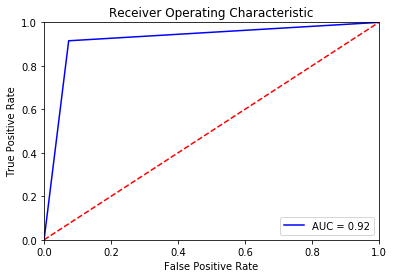

In [581]:
fprc, tprc, threshold = roc_curve(y_test, predictionslrc)
roc_auc_cvec = auc(fprc, tprc)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b', label = 'AUC = %0.2f' % roc_auc_cvec)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


There is high AUC score 

In [582]:
#words and their coefficients in the logistic regression model were placed into a dataframe
colcoefc = pd.DataFrame()
colcoefc['words'] = [x for x in X_test_cveclr.columns]
colcoefc['coeff'] = [y for y in lrc.coef_[0]]

### The top 50 words that indicate positive odds of being a r/JUSTNOMIL post

The table shows the top 50 stemmed words that have high odds of being in a r/JUSTNOMIL post

In [583]:
jnmlrwords = [x for x in colcoefc.sort_values(by = 'coeff', ascending = False).head(50)['words']]

In [584]:
print(jnmlrwords)

['dh', 'wedding', 'husband', 'mom', 'house', 'jnmil', 'baby', 'sil', 'mother', 'jnmom', 'fdh', 'family', 'fmil', 'daughter', 'jn', 'control', 'white', 'boundary', 'fianc', 'fil', 'thread', 'done', 'going', 'live', 'important', 'today', 'shut', 'clearly', 'moving', 'caught', 'thank', 'much', 'involved', 'lo', 'mil', 'lady', 'kind', 'nc', 'woman', 'allowed', 'grandma', 'deleted', 'dinner', 'wish', 'il', 'bitch', 'oh', 'whatever', 'guilt', 'surgery']


### The top 50 words that indicate negative odds of being a r/relationship_advice post

The table shows the top 50 stemmed words that have lowest odds of being a r/relationship_advice post

In [585]:
#top 50 words that indicate positive relationship to being a r/relationships post
rshipswords = [x for x in colcoefc.sort_values(by = 'coeff', ascending = True).head(50)['words']]

In [586]:
print(rshipswords)

['friend', 'girlfriend', 'girl', 'night', 'saw', 'recently', 'bed', 'together', 'sex', 'month', 'love', 'cheating', 'half', 'broke', 'divorce', 'reddit', 'talking', 'sunday', 'text', 'give', 'idea', 'high', 'situation', 'wondering', 'someone', 'type', 'fear', 'mad', 'year', 'guy', 'really', 'trouble', 'man', 'scared', 'truck', 'wanna', 'fix', 'abusive', 'find', 'experience', 'heart', 'meet', 'break', 'dating', 'care', 'open', 'person', 'etc', 'gf', 'upset']


### Naive Bayes Method

A pipeline was created to run GridSearch for optimum parameters.

In [587]:
# Pipeline was created
pipenbc = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
                ])

In [588]:
# the parameters to be tested by the pipeline 
paramnbc = {'cvec__max_features': [2000, 2500, 3000, 3500],\
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)]}

In [589]:
#gridsearch was initialised and the training set was fitted into it
gridnbc = GridSearchCV(pipenbc, param_grid=paramnbc, cv = 5, verbose = 1)
gridnbc.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  8.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'cvec__max_features': [2000, 2500, 3000, 3500], 'cvec__min_df': [2, 3], 'cvec__max_df': [0.9, 0.95], 'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [590]:
#the parameters that gave the best score
gridnbc.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 3)}

In [591]:
gridnbc.best_score_

0.942489851150203

In [592]:
# using the same parameters, the score was generated for the test datasets
gridnbc.score(X_test, y_test)

0.9553752535496958

In [594]:
# tfidfvectorizer was initialised with the parameters that was found using gridsearch
cvecnb = CountVectorizer(max_df = 0.9, max_features = 3000, min_df = 2, ngram_range=(1,3))

In [595]:
#X_train data fit graph and the words were vectorised into different columns
X_train_cvecnb = pd.DataFrame(cvecnb.fit_transform(X_train).toarray(),columns = cvecnb.get_feature_names()) 

In [596]:
#X_train data fit graph and the words were vectorised into different columns
X_test_cvecnb = pd.DataFrame(cvecnb.transform(X_test).toarray(),columns = cvecnb.get_feature_names()) 

In [597]:
# initialising Multinomial Naive Bayes
nbc = MultinomialNB()

In [598]:
# Fit our model!
modelnbc = nbc.fit(X_train_cvecnb, y_train)

In [599]:
predictionsc = modelnbc.predict(X_test_cvecnb)

In [600]:
scorenbc_train = modelnbc.score(X_train_cvecnb, y_train)
scorenbc_train

0.9634641407307172

In [601]:
scorenbc_test = modelnbc.score(X_test_cvecnb, y_test)
scorenbc_test

0.9553752535496958

### Confusion matrix was extracted.

In [602]:
confusion_matrix(y_test, predictionsc)

array([[227,  18],
       [  4, 244]])

In [603]:
tnnbc, fpnbc, fnnbc, tpnbc = confusion_matrix(y_test, predictionsc).ravel()

In [604]:
print("True Negatives: %s" % tnnbc)
print("False Positives: %s" % fpnbc)
print("False Negatives: %s" % fnnbc)
print("True Positives: %s" % tpnbc)

True Negatives: 227
False Positives: 18
False Negatives: 4
True Positives: 244


In [605]:
acc_cvecnb = (tnnbc+tpnbc)/(tnnbc+fpnbc+fnnbc+tpnbc)

### ROC Curve

A ROC curve was plotted to see the AUC score:

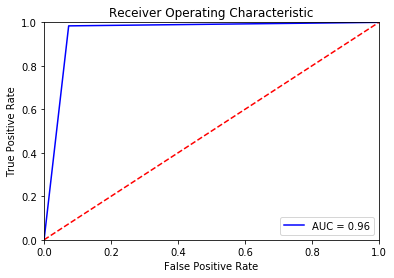

In [606]:
fprnbc, tprnbc, thresholdnbc = roc_curve(y_test, predictionsc)
roc_aucnbc = auc(fprnbc, tprnbc)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fprnbc, tprnbc, 'b', label = 'AUC = %0.2f' % roc_aucnbc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


The ROC curve gave a AUCs score of 0.95, which is shows that the Naive Bayes model is excellent in classifying the words into the correct subreddit.

In [607]:
# collating the nb feature probabilities (normalised) into one dataframe
nbccolcoef = pd.DataFrame()
nbccolcoef['words'] = [x for x in X_test_cvecnb.columns]
nbccolcoef['jnm'] = [np.exp(y) for y in nbc.feature_log_prob_[1]]
nbccolcoef['rships'] = [np.exp(y) for y in nbc.feature_log_prob_[0]]

In [608]:
#top 50 words that indicate positive relationship to being a r/justnomil post
jnmnbc = [y for y in nbccolcoef.sort_values(by = 'jnm', ascending = False).head(50)['words']]

In [609]:
print(jnmnbc)

['wa', 'like', 'time', 'ha', 'get', 'would', 'want', 'know', 'dh', 'said', 'family', 'one', 'told', 'thing', 'year', 'go', 'going', 'mom', 'day', 'even', 'mother', 'say', 'back', 'house', 'make', 'got', 'never', 'see', 'really', 'also', 'think', 'feel', 'husband', 'need', 'well', 'tell', 'come', 'baby', 'could', 'much', 'week', 'kid', 'wanted', 'month', 'way', 'first', 'home', 'still', 'child', 'life']


In [610]:
#top 50 words that indicate positive relationship to being a r/relationships post
rshipsnbc = [y for y in nbccolcoef.sort_values(by = 'rships', ascending = False).head(50)['words']]

In [611]:
print(rshipsnbc)

['wa', 'like', 'time', 'want', 'know', 'friend', 'feel', 'thing', 'ha', 'would', 'get', 'really', 'year', 'said', 'told', 'one', 'go', 'month', 'even', 'day', 'make', 'think', 'together', 'never', 'going', 'back', 'say', 'still', 'work', 'got', 'love', 'much', 'always', 'also', 'way', 'started', 'guy', 'girl', 'see', 'since', 'life', 'talk', 'week', 'tell', 'feel like', 'something', 'lot', 'feeling', 'boyfriend', 'could']


Text(0.5, 1.0, 'Venn Diagram of overlapping high probability words from r/JUSTNOMIL and r/relationship_advice (C-vec)')

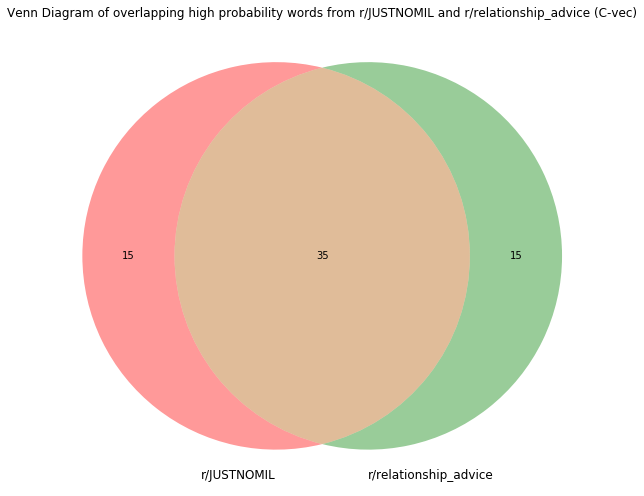

In [682]:
plt.figure(figsize = (10,10))
venn_cvec = venn2([set(jnmnbc), set(rshipsnbc)], set_labels = ('r/JUSTNOMIL', 'r/relationship_advice'))
plt.title('Venn Diagram of overlapping high probability words from r/JUSTNOMIL and r/relationship_advice (C-vec)')

The Venn Diagram shows that out of the top 50 words that have the highest probability of being present in the subreddit, 35 are similar. This means that only 15 of the 50 highest probabilities are unique to the either subreddit. 

In [613]:
#Finding the unique 15 words for r/JUSTNOMIL 
uniqjnm = []
commonnbc = []
count = 0
for x in jnmnbc: 
    count = 0
    for y in rshipsnbc: 
        if x == y:
            count += 1
        else:
            next
    if count <1: 
        uniqjnm.append(x)
    else:
        commonnbc.append(x)
print(uniqjnm)
print(commonnbc)

['dh', 'family', 'mom', 'mother', 'house', 'husband', 'need', 'well', 'come', 'baby', 'kid', 'wanted', 'first', 'home', 'child']
['wa', 'like', 'time', 'ha', 'get', 'would', 'want', 'know', 'said', 'one', 'told', 'thing', 'year', 'go', 'going', 'day', 'even', 'say', 'back', 'make', 'got', 'never', 'see', 'really', 'also', 'think', 'feel', 'tell', 'could', 'much', 'week', 'month', 'way', 'still', 'life']


In [614]:
#Finding the unique 15 words for r/relationship_advice
uniqrships = []
count = 0
for x in rshipsnbc: 
    count = 0
    for y in jnmnbc: 
        if x == y:
            count += 1
        else:
            next
    if count <1: 
        uniqrships.append(x)
        
print(uniqrships)

['friend', 'together', 'work', 'love', 'always', 'started', 'guy', 'girl', 'since', 'talk', 'feel like', 'something', 'lot', 'feeling', 'boyfriend']


## Alternative Vectorising: TD-IDF

A pipeline using TF-IDF vectorizer and logistic regression was created to find optimal conditions for TF-IDF vectorizer parameters.

TF-IDF vectorizer was explored as it penalised more common words and promoted rarer words.

In [615]:
# Pipeline was created: Logistic regression with TF-IDF
pipelrt = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
                ])

In [616]:
# the parameters to be tested by the pipeline for: Logistic regression with TF-IDF
paramlrt = {'tvec__max_features': [2000, 2500, 3000, 3500],\
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)]}

In [617]:
#gridsearch was initialised and the training set was fitted into it
gridlrt = GridSearchCV(pipelrt, param_grid=paramlrt, cv = 5, verbose = 1)
gridlrt.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ongzhongliang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  8.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'tvec__max_features': [2000, 2500, 3000, 3500], 'tvec__min_df': [2, 3], 'tvec__max_df': [0.9, 0.95], 'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [618]:
#the parameters that gave the best score
gridlrt.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 2000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1)}

In [619]:
gridlrt.best_score_

0.9438430311231394

In [620]:
# using the same parameters, the score was generated for the test datasets
gridlrt.score(X_test, y_test)

0.9553752535496958

In [621]:
# tfidfvectorizer was initialised with the parameters that was found using gridsearch
tveclr = TfidfVectorizer(max_df = 0.9, max_features = 2000, min_df = 2, ngram_range=(1,1))

In [622]:
#X_train data fit graph and the words were vectorised into different columns
X_train_tveclr = pd.DataFrame(tveclr.fit_transform(X_train).toarray(),columns = tveclr.get_feature_names()) 

In [623]:
#list of words vectorised
tvec_col_lr = tveclr.get_feature_names()

In [624]:
print(X_train_tveclr.shape)

(1478, 2000)


In [625]:
#X_test words were vectorised into different columns
X_test_tveclr = pd.DataFrame(tveclr.transform(X_test).toarray(), columns = tveclr.get_feature_names()) #transform the X_test data

#### Logistic Regression was performed

In [626]:
# logistic regression initialised
lrt = LogisticRegression()

In [627]:
# X_train data fitted
modellrt = lrt.fit(X_train_tveclr, y_train)

In [628]:
#score for model was found
scorelrt = lrt.score(X_test_tveclr, y_test)

In [629]:
scorelrt

0.9553752535496958

In [630]:
predictionslrt = modellrt.predict(X_test_tveclr)

#### Creating a confusion matrix to show the distribution of correctly classified and incorrectly classified posts 

TF-IDF and Logistic Regression

In [631]:
confusion_matrix(y_test, predictionslrt)

array([[230,  15],
       [  7, 241]])

In [632]:
# splitting the confusion matrix into its components
tnlrt, fplrt, fnlrt, tplrt = confusion_matrix(y_test, predictionslrt).ravel() 

In [633]:
print("True Negatives: %s" % tnlrt)
print("False Positives: %s" % fplrt)
print("False Negatives: %s" % fnlrt)
print("True Positives: %s" % tplrt)

True Negatives: 230
False Positives: 15
False Negatives: 7
True Positives: 241


In [634]:
acc_tveclr = (tnlrt+tplrt)/(tnlrt+fplrt+fnlrt+tplrt)

### ROC Curve: TF-IDF Vectoriser and Logistic Regression

A ROC curve was plotted to see the AUC score: 

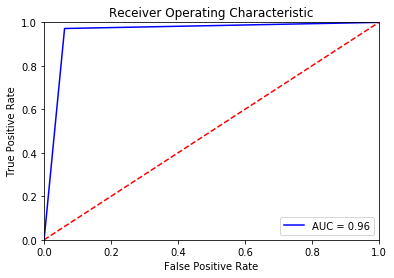

In [635]:
fprtlr, tprtlr, thresholdtlr = roc_curve(y_test, predictionslrt)
roc_auctlr = auc(fprtlr, tprtlr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fprtlr, tprtlr, 'b', label = 'AUC = %0.2f' % roc_auctlr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [636]:
#words and their coefficients in the logistic regression model were placed into a dataframe
colcoeft = pd.DataFrame()
colcoeft['words'] = [x for x in X_test_tveclr.columns]
colcoeft['coeff'] = [y for y in lrt.coef_[0]]

### The top 50 words that indicate positive odds of being a r/JUSTNOMIL post

The table shows the top 50 stemmed words that have high odds of being in a r/JUSTNOMIL post

In [637]:
colcoeft.sort_values(by = 'coeff', ascending = False).head(50)

,words,coeff
486,dh,4.572308
1162,mom,3.601601
1172,mother,2.954733
890,husband,2.627416
632,family,2.278157
874,house,2.261327
1932,wedding,2.259335
141,baby,2.107022
963,jnmil,1.919277
1639,son,1.813520


### The top 50 words that indicate positive odds of being a r/relationship_advice post

The table shows the top 50 stemmed words that have high odds of being in a r/relationship_advice post

In [638]:
#top 10 words that indicate positive relationship to being a r/relationships post
colcoeft.sort_values(by = 'coeff', ascending = True).head(50)

,words,coeff
721,friend,-3.420371
754,girl,-2.242959
1809,together,-2.056466
1568,sex,-2.017429
755,girlfriend,-2.011094
1077,love,-1.606201
804,guy,-1.603783
646,feel,-1.534005
1436,really,-1.513575
1042,like,-1.483335


### Naive Bayes Method

Naive Bayes was initialised to classify the Tf-IDF vectorised words.

In [639]:
# Pipeline was created: TF-IDF with Naive Bayes
pipenbt = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
                ])

In [640]:
# the parameters to be tested by the pipeline 
paramnbt = {'tvec__max_features': [2000, 2500, 3000, 3500],\
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)]}

In [641]:
#gridsearch was initialised and the training set was fitted into it
gridnbt = GridSearchCV(pipenbt, param_grid=paramnbt, cv = 5, verbose = 1)
gridnbt.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  9.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...True,
        vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'tvec__max_features': [2000, 2500, 3000, 3500], 'tvec__min_df': [2, 3], 'tvec__max_df': [0.9, 0.95], 'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [642]:
#the parameters that gave the best score
gridnbt.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 3000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 3)}

In [643]:
gridnbt.best_score_

0.9445196211096076

In [644]:
# using the same parameters, the score was generated for the test datasets
gridnbt.score(X_test, y_test)

0.9574036511156186

In [645]:
# tfidfvectorizer was initialised with the parameters that was found using gridsearch
tvecnb = TfidfVectorizer(max_df = 0.9, max_features = 3000, min_df = 2, ngram_range=(1,3))

In [646]:
#X_train data fit graph and the words were vectorised into different columns
X_train_tvecnb = pd.DataFrame(tvecnb.fit_transform(X_train).toarray(),columns = tvecnb.get_feature_names()) 

In [647]:
#X_train data fit graph and the words were vectorised into different columns
X_test_tvecnb = pd.DataFrame(tvecnb.transform(X_test).toarray(),columns = tvecnb.get_feature_names()) 

In [648]:
# initialising Multinomial Naive Bayes
nbt = MultinomialNB()

In [649]:
# Fit our model!
modelnbt = nbt.fit(X_train_tvecnb, y_train)

In [650]:
predictionstnb = modelnbt.predict(X_test_tvecnb)

In [651]:
scorenbt_train = modelnbt.score(X_train_tvecnb, y_train)
scorenbt_train

0.9641407307171854

In [652]:
scorenbt_test = modelnbt.score(X_test_tvecnb, y_test)
scorenbt_test

0.9574036511156186

In [653]:
confusion_matrix(y_test, predictionstnb)

array([[229,  16],
       [  5, 243]])

In [654]:
tnnbt, fpnbt, fnnbt, tpnbt = confusion_matrix(y_test, predictionstnb).ravel()

In [655]:
print("True Negatives: %s" % tnnbt)
print("False Positives: %s" % fpnbt)
print("False Negatives: %s" % fnnbt)
print("True Positives: %s" % tpnbt)

True Negatives: 229
False Positives: 16
False Negatives: 5
True Positives: 243


In [656]:
acc_tvecnb = (tnnbt+tpnbt)/(tnnbt+fpnbt+fnnbt+tpnbt)

### ROC Curve: TF-IDF with Naive Bayes

A ROC curve was plotted to see the AUC score:

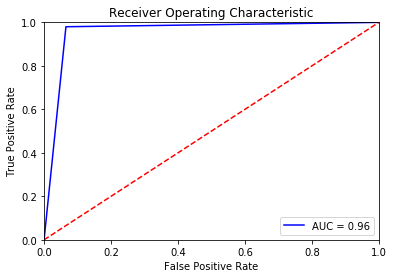

In [657]:
fprnbt, tprnbt, thresholdnbt = roc_curve(y_test, predictionstnb)
roc_aucnbt = auc(fprnbt, tprnbt)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fprnbt, tprnbt, 'b', label = 'AUC = %0.2f' % roc_aucnbt)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [658]:
# collating all the probabilities together
nbtcolcoef = pd.DataFrame()
nbtcolcoef['words'] = [x for x in X_test_tvecnb.columns]
nbtcolcoef['jnm'] = [np.exp(y) for y in nbt.feature_log_prob_[1]]
nbtcolcoef['rships'] = [np.exp(y) for y in nbt.feature_log_prob_[0]]

In [659]:
#top 50 words that indicate positive relationship to being a r/justnomil post
jnmnbtwords = [x for x in nbtcolcoef.sort_values(by = 'jnm', ascending = False).head(50)['words']]
print(jnmnbtwords)

['wa', 'dh', 'ha', 'mom', 'get', 'family', 'time', 'like', 'would', 'want', 'mother', 'know', 'husband', 'said', 'told', 'going', 'baby', 'one', 'year', 'house', 'go', 'thing', 'day', 'kid', 'son', 'say', 'child', 'see', 'even', 'back', 'never', 'got', 'sil', 'need', 'make', 'think', 'well', 'come', 'also', 'wedding', 'week', 'tell', 'feel', 'really', 'much', 'daughter', 'could', 'home', 'call', 'parent']


In [660]:
#top 50 words that indicate positive relationship to being a r/relationship_advice post
rshipsnbtwords = [x for x in nbtcolcoef.sort_values(by = 'rships', ascending = False).head(50)['words']]
print(rshipsnbtwords)

['wa', 'like', 'friend', 'feel', 'want', 'know', 'time', 'really', 'thing', 'year', 'ha', 'would', 'get', 'girl', 'love', 'together', 'month', 'guy', 'said', 'boyfriend', 'one', 'sex', 'told', 'go', 'work', 'think', 'day', 'make', 'even', 'still', 'feel like', 'feeling', 'always', 'back', 'never', 'started', 'talk', 'say', 'got', 'girlfriend', 'going', 'way', 'also', 'much', 'since', 'lot', 'help', 'something', 'dating', 'life']


Text(0.5, 1.0, 'Venn Diagram of overlapping high probability words from r/JUSTNOMIL and r/relationship_advice (T-Vec)')

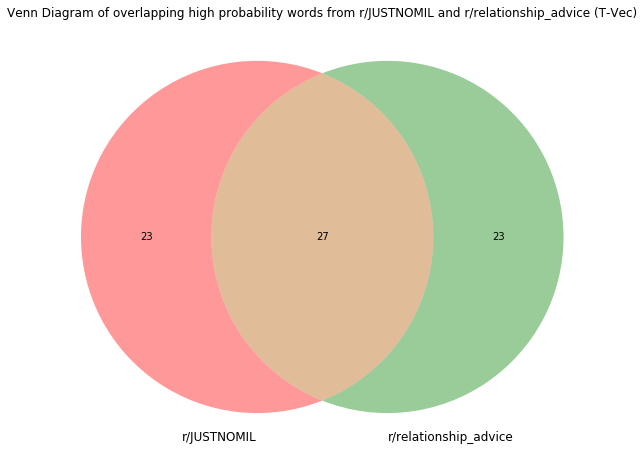

In [683]:
plt.figure(figsize = (10,10))
venn_tvec = venn2([set(jnmnbtwords), set(rshipsnbtwords)], set_labels = ('r/JUSTNOMIL', 'r/relationship_advice'))
plt.title('Venn Diagram of overlapping high probability words from r/JUSTNOMIL and r/relationship_advice (T-Vec)')

The Venn Diagram shows that out of the top 50 words that have the highest probability of being present in the subreddit, 27 are similar. This means that only 23 of the 50 highest probabilities are unique to the either subreddit. 

In [684]:
#Finding the unique 23 words for r/JUSTNOMIL 
uniqjnmt = []
count = 0
commonnbt = []
for x in jnmnbtwords: 
    count = 0
    for y in rshipsnbtwords: 
        if x == y:
            count += 1
        else:
            next
    if count <1: 
        uniqjnmt.append(x)
    else:
        commonnbt.append(x)
                
print(uniqjnmt)
print(commonnbt)

['dh', 'mom', 'family', 'mother', 'husband', 'baby', 'house', 'kid', 'son', 'child', 'see', 'sil', 'need', 'well', 'come', 'wedding', 'week', 'tell', 'daughter', 'could', 'home', 'call', 'parent']
['wa', 'ha', 'get', 'time', 'like', 'would', 'want', 'know', 'said', 'told', 'going', 'one', 'year', 'go', 'thing', 'day', 'say', 'even', 'back', 'never', 'got', 'make', 'think', 'also', 'feel', 'really', 'much']


In [663]:
#Finding the unique 23 words for r/relationships 
uniqrshipst = []
count = 0
for x in rshipsnbtwords: 
    count = 0
    for y in jnmnbtwords: 
        if x == y:
            count += 1
        else:
            next
    if count <1: 
        uniqrshipst.append(x)
        
print(uniqrshipst)

['friend', 'girl', 'love', 'together', 'month', 'guy', 'boyfriend', 'sex', 'work', 'still', 'feel like', 'feeling', 'always', 'started', 'talk', 'girlfriend', 'way', 'since', 'lot', 'help', 'something', 'dating', 'life']


## Conclusion: 

In [665]:
conclusion = pd.DataFrame()
conclusion['Vectoriser/Model'] = ['CountVectorizer + Logistic Regression', \
                                  'TF-IDFVectorizer + Logistic Regression',\
                                 'CountVectorizer + Naive Bayes',\
                                 'TF-IDFVectorizer + Naive Bayes']
#conclusion['Score'] = [scorelrc, scorelrt, scorenbc_test, scorenbt_test]
conclusion['AUC Score'] = [roc_auc_cvec, roc_auctlr, roc_aucnbc, roc_aucnbt]
conclusion['Accuracy'] = [acc_cveclr, acc_tveclr, acc_cvecnb, acc_tvecnb]
conclusion['TP'] = [tplrc, tplrt, tpnbc, tpnbt]
conclusion['TN'] = [tnlrc, tnlrt, tnnbc, tnnbt]
conclusion['FP'] = [fplrc, fplrt, fpnbc, fpnbt]
conclusion['FN'] = [fnlrc, fnlrt, fnnbc, fnnbt]
conclusion

,Vectoriser/Model,AUC Score,Accuracy,TP,TN,FP,FN
0,CountVectorizer + Logistic Regression,0.920927,0.920892,227,227,18,21
1,TF-IDFVectorizer + Logistic Regression,0.955275,0.955375,241,230,15,7
2,CountVectorizer + Naive Bayes,0.955201,0.955375,244,227,18,4
3,TF-IDFVectorizer + Naive Bayes,0.957266,0.957404,243,229,16,5


All models have acceptable scores, with both models scoring consistently above 0.90. 

In addition, the overall accuracy of the Logistic Regression model seem to be less accurate. It might not be favourable to use Logistric Regression to classify posts as the nature of r/JUSTNOMIL can often require specific advice from other likeminded individuals, and the severity of r/JUSTNOMIL posts might require immediate attention.

Thus, the Naive Bayes model has more merit as classifier as it is able to firstly classifies less wrong posts, and secondly, it has a higher AUC score in general

Furthermore, there is a slight advantage of using TF-IDF word vectorizer as the models using it contains less false positives.

### Limitations of Logistic Regression

Logistic Regression is known to run slower than Naive Bayes when dealing with smaller datasets. 

### Limitations of Naive Bayes

The results are difficult to interpret as there are overlapping words with equal high probabilities of being posts from either subreddit.

### Possible Future Steps of Action

It is possible to explore the following courses of action:
- introducing regularisation to the logistic regression model
- try decision trees instead
- develop tool further to decide on danger level of poster. 